# Airspace Data Analysis - Michael Griffith 
#### This notebook was created to analysis a subset of data provided by Airspace for the purposes of presenting my programming and data analysis skills.

## Python Version and Libraries Used in Notebook
#### Used Python Version 3.7.9

In [65]:
# used to pull csv file from github website
import requests
# used to pull csv from github website
import io
# used to create and manipulate dataframes within notebook
import pandas as pd
# used to add nan values to dataframes
import numpy as np
# used to calculate distances between zip codes
import pgeocode
# used to pull zip code radii data and update distances
from uszipcode import SearchEngine
# used to create graphs within notebook
from matplotlib import pyplot as plt
# used to calculate correlation coefficients between series in dataframes
from scipy import stats

## Download csv directly from GitHub repo
## Create dataframe from downloaded csv

In [66]:
# url for csv file on github page
url = "https://raw.githubusercontent.com/chrisairspace/data-tech-screening/main/order_records.csv"

# download csv file contents from github
download = requests.get(url).content

# create StringIO file object to input into Pandas
download=io.StringIO(download.decode('utf-8'))

# adjusts jupyter notebook settings to allow full width of dataframes/tables
pd.set_option('display.width', None)

# adjust jupyter notebook settings to display more rows
pd.set_option('display.max_rows', 10000)

# Read in csv file and use first column of values as row indexes
df = pd.read_csv(download, index_col=0)

# Print data types for each column
print('Data types for each column in dataset')
print(df.dtypes)
print('\n')
print('First 5 rows of data in dataframe')

# Look at first 5 rows of data
## style dataframe to hide row index and set decimal place values to 2
df.head().style.hide_index().set_precision(2)

Data types for each column in dataset
ORDER_ID          int64
COMPANY_ID        int64
SERVICE_LINE      int64
DRIVER_TYPE      object
WEIGHT_LBS      float64
VOLUME_IN3      float64
EXPENSE         float64
PICKUP_ZIP       object
DELIVERY_ZIP     object
dtype: object


First 5 rows of data in dataframe


ORDER_ID,COMPANY_ID,SERVICE_LINE,DRIVER_TYPE,WEIGHT_LBS,VOLUME_IN3,EXPENSE,PICKUP_ZIP,DELIVERY_ZIP
100001,589,1,commander,65.00,19008.00,304.93,77054,76104
100002,586,2,commander,150.00,18816.00,354.10,75209,77061
100003,451,2,agent,1110.00,85248.00,306.83,32607,33607
100004,30,1,commander,8.00,528.00,36.83,27704,27710
100005,1166,1,commander,80.00,9408.00,611.27,19403,28138


## Check for null values

In [67]:
# checks for null values in each column of dataframe
for c in df.columns:
    if df[c].isnull().value_counts().shape[0] == 1:
        print(f'{c} has no null values')
    else:
        print(f'{c} has null values')


ORDER_ID has no null values
COMPANY_ID has no null values
SERVICE_LINE has no null values
DRIVER_TYPE has no null values
WEIGHT_LBS has no null values
VOLUME_IN3 has no null values
EXPENSE has no null values
PICKUP_ZIP has no null values
DELIVERY_ZIP has no null values


## Investigate zip code formats

In [68]:
# Display zip codes for investigation
df[['PICKUP_ZIP','DELIVERY_ZIP']].style.hide_index()


PICKUP_ZIP,DELIVERY_ZIP
77054,76104
75209,77061
32607,33607
27704,27710
19403,28138
10451,10021
44143,10604
27704,27514
10451,10016
10451,11794


#### It appears there are several zip codes with a zip code extension and several zip codes with less than 5 characters (invalid for US zip codes). The pgeocode library requires a 5 digit zipcode to calcualte distances so I will trim all zip codes to 5 digits. I investigated several of the zipcodes with less than 5 digits and found what appears to be several data errors (95, 201, 153, etc). The zip code 7608 shows up in many records which is either an error or the postal code for a city in New Zealand. Since this appears to be US based trucking orders, I'll assume the 7608 zip code is an error. I will assume all zip codes with less than 5 digits are the result of an error and change them to NaN which will only affect the resulting distance calculation. This can also be filtered later for anyone wishing to look into the data and solve the root of the error. 

## Manipulate non standard zip codes

In [69]:
# Trim zip codes to 5 digits
df['PICKUP_ZIP'] = df['PICKUP_ZIP'].str.strip().str.slice(stop=5)
df['DELIVERY_ZIP'] = df['DELIVERY_ZIP'].str.strip().str.slice(stop=5)

# Change zip codes with less than 5 digits to NaN
df.loc[df['PICKUP_ZIP'].str.len()<5, 'PICKUP_ZIP'] = np.nan
df.loc[df['DELIVERY_ZIP'].str.len()<5, 'DELIVERY_ZIP'] = np.nan

# calculate number of rows that have nan zips
nan_zips = df[df['PICKUP_ZIP'].isnull() | df['DELIVERY_ZIP'].isnull()].shape[0]
print(f'There are {nan_zips} orders that had an invalid delivery or pickup zip code')
print('\n')
print('First 5 rows of data with updated null zip codes')

# display first 5 rows of data with nan zip codes
df[df['PICKUP_ZIP'].isnull() | df['DELIVERY_ZIP'].isnull()].head().style.hide_index().set_precision(2)

There are 48 orders that had an invalid delivery or pickup zip code


First 5 rows of data with updated null zip codes


ORDER_ID,COMPANY_ID,SERVICE_LINE,DRIVER_TYPE,WEIGHT_LBS,VOLUME_IN3,EXPENSE,PICKUP_ZIP,DELIVERY_ZIP
100033,980,1,commander,1.00,189.75,75.60,10461,nan
100078,980,1,commander,1.00,128.00,72.34,11554,nan
100419,980,1,commander,2.00,288.00,89.06,10901,nan
100511,980,1,commander,1.00,189.75,45.39,11237,nan
100584,371,1,commander,5.00,125.00,42.30,nan,95834


#### There are 48 orders with with errorenous zip codes. That is ~0.5% of the dataset. I would have someone investigate the source of the error here. For now I've updated the erroneous zip codes with null values. 

## Calculate distances between zip codes using pgeocode

In [70]:
# pgeocode requires country selection
dist = pgeocode.GeoDistance('us')

# calculate distance based on pickup and delivery zipcodes
## output is in km, multipled output by 0.62 to get miles
## multipled output by 1.1 to account for driving routes not being a straight line for distance
df['DISTANCE_MI'] = dist.query_postal_code(df['PICKUP_ZIP'].array,df['DELIVERY_ZIP'].array)*0.621371*1.1


print('First 5 rows of data with distance calculations')
# display top 5 rows of new dataframe
df.head().style.hide_index().set_precision(2)

First 5 rows of data with distance calculations


ORDER_ID,COMPANY_ID,SERVICE_LINE,DRIVER_TYPE,WEIGHT_LBS,VOLUME_IN3,EXPENSE,PICKUP_ZIP,DELIVERY_ZIP,DISTANCE_MI
100001,589,1,commander,65.00,19008.00,304.93,77054,76104,262.51
100002,586,2,commander,150.00,18816.00,354.10,75209,77061,261.77
100003,451,2,agent,1110.00,85248.00,306.83,32607,33607,128.05
100004,30,1,commander,8.00,528.00,36.83,27704,27710,1.51
100005,1166,1,commander,80.00,9408.00,611.27,19403,28138,462.25


#### Orders with the same pickup and delivery zip codes result in a 0 mile distance calculation. There is another python library that contains data on zip code radii, which could be used as an average distance traveled within a zipcode.

## Use zip code radius to estimate distance for trips within zip code

In [71]:
# downloads simple_zipcode database (9MB)
search = SearchEngine(simple_zipcode=True)

# filter for records with the same pickup and delivery zipcodes, pass delivery zip to uszipcode function 
## pull zipcode radius and pass to distance_mi column
df.loc[df['PICKUP_ZIP']==df['DELIVERY_ZIP'],'DISTANCE_MI'] = df.apply(lambda x: search.by_zipcode(x['DELIVERY_ZIP']).to_dict()['radius_in_miles'],axis=1) 

print('Distances for orders with the same pickup and delivery zip code')

# display distance_mi data for records where pickup and delivery zipcode are the same
df.loc[df['PICKUP_ZIP']==df['DELIVERY_ZIP'],['PICKUP_ZIP','DELIVERY_ZIP','DISTANCE_MI']].style.hide_index().set_precision(2)

Distances for orders with the same pickup and delivery zip code


PICKUP_ZIP,DELIVERY_ZIP,DISTANCE_MI
77030,77030,1.00
78229,78229,2.00
10021,10021,0.91
92346,92346,6.00
93534,93534,7.00
93534,93534,7.00
78229,78229,2.00
90045,90045,2.00
77030,77030,1.00
92346,92346,6.00


## Distances for orders with same delivery and pickup zip codes

In [72]:
# print total number of records where pickup and delivery zipcodes are the same
same_zips=df.loc[df['PICKUP_ZIP']==df['DELIVERY_ZIP'],['DELIVERY_ZIP','DISTANCE_MI']].shape[0]
print(f'There are {same_zips} orders with the same pickup and delivery zip code')
print('\n')

# print frequency of distances for order with same delivery and pickup zips
print('Frequency of distances for orders with the same delivery and pickup zipcode')
df.loc[df['PICKUP_ZIP']==df['DELIVERY_ZIP'],'DISTANCE_MI'].value_counts(dropna=False)

There are 396 orders with the same pickup and delivery zip code


Frequency of distances for orders with the same delivery and pickup zipcode


3.000000     72
2.000000     52
8.000000     45
1.000000     44
5.000000     44
NaN          31
6.000000     30
4.000000     28
7.000000     20
0.909091     12
9.000000      4
0.681818      3
12.000000     2
0.795455      2
0.511364      2
10.000000     1
15.000000     1
34.000000     1
17.000000     1
16.000000     1
Name: DISTANCE_MI, dtype: int64

#### There are 396 orders where the pickup and delivery zipcode are the same. Of that subset I was able to estimate the order distance from the zipcode radius for 365 orders (92%). Large improvement in distance data quality.

## Summary Values

In [73]:
# Calculate unique number of Company IDs
a = df['COMPANY_ID'].nunique()

# Create order weight data summary table
data_w = {'Total_Weight':[df['WEIGHT_LBS'].sum().round(decimals=2)],\
          'Max_Weight':[df['WEIGHT_LBS'].max().round(decimals=2)],\
          'Min_Weight':[df['WEIGHT_LBS'].min().round(decimals=2)],\
          'Avg_Weight':[df['WEIGHT_LBS'].mean().round(decimals=2)]}
df_w = pd.DataFrame(data=data_w)

# Create order volume data summary table
data_v = {'Total_Volume':[df['VOLUME_IN3'].sum().round(decimals=2)],\
          'Max_Volume':[df['VOLUME_IN3'].max().round(decimals=2)],\
          'Min_Volume':[df['VOLUME_IN3'].min().round(decimals=2)],\
          'Avg_Volume':[df['VOLUME_IN3'].mean().round(decimals=2)]}
df_v = pd.DataFrame(data=data_v)

# Create order distance data summary table
data_d = {'Total_Distance':[df['DISTANCE_MI'].sum().round(decimals=2)],\
          'Max_Distance':[df['DISTANCE_MI'].max().round(decimals=2)],\
          'Min_Distance':[df['DISTANCE_MI'].min().round(decimals=2)],\
          'Avg_Distance':[df['DISTANCE_MI'].mean().round(decimals=2)]}
df_d = pd.DataFrame(data=data_d)

#Create order expense data summary table
data_e = {'Total_Expense':[df['EXPENSE'].sum().round(decimals=2)],\
          'Max_Expense':[df['EXPENSE'].max().round(decimals=2)],\
          'Min_Expense':[df['EXPENSE'].min().round(decimals=2)],\
          'Avg_Expense':[df['EXPENSE'].mean().round(decimals=2)]}
df_e = pd.DataFrame(data=data_e)

# Print number of unique customers in dataset
print(f'There are {a} customers in this dataset')
print('\n')

# Display tables
print('Order weight summary info')
print(df_w.to_string(index=False))
print('\n')

print('Order volume summary info')
print(df_v.to_string(index=False))
print('\n')

print('Order distance summary info')
print(df_d.to_string(index=False))
print('\n')

print('Order expense summary info')
print(df_e.to_string(index=False))

There are 244 customers in this dataset


Order weight summary info
 Total_Weight  Max_Weight  Min_Weight  Avg_Weight
    735501.17    500000.0         0.0       73.55


Order volume summary info
 Total_Volume  Max_Volume  Min_Volume  Avg_Volume
  53901833.35    975240.0         0.0     5390.18


Order distance summary info
 Total_Distance  Max_Distance  Min_Distance  Avg_Distance
      616268.19        2653.7          0.39         62.15


Order expense summary info
 Total_Expense  Max_Expense  Min_Expense  Avg_Expense
    1215937.65       5014.0          0.0       121.59


#### There appear to be values of 0 for weight, volume, and expense. An order can't physically have a volume or weight of 0, but perhaps a value of 0 is used for something like a document delivery. It also doesn't make sense to have orders with an expense of 0. I would need to know more information about the tracking and pricing business processes to know if these are true data errors, but its worth noting. Will investigate further below.

#### Another data point worth looking at is the order with a weight of 500,000lbs. That doesn't seem physically possible custom equipment. A quick google search shows that federal law sets a max vehicle gross weight of 80,000lbs. I'm sure there are methods to work around larger loads but it seems more probable that this is a data error. This should be validated with someone who know more about his specific order.

## Order with weight 500000 lbs

In [97]:
df.loc[df['WEIGHT_LBS']==df['WEIGHT_LBS'].max(),['ORDER_ID', 'WEIGHT_LBS']].style.hide_index().set_precision(0)

ORDER_ID,WEIGHT_LBS
105002,500000


## Histograms of Order Data

#### Because the volume/weight/expense/distance data has such large ranges, I can't simply use built in histogram functions to create a nice graph. I will need to manually bucket the values and assign equally spaced scalar values for each bucket so that they graph nicely.

### Order Weight Histogram

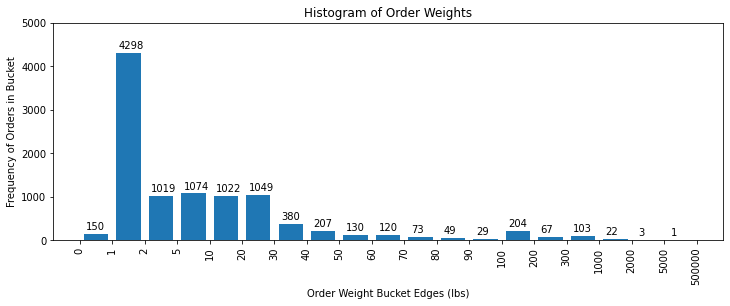

In [74]:
%matplotlib inline

# Define function to bucket weights into format that can be equally spaced on graph
def bins_w(row):
    if 0 <= row < 1:
        bin_val = 1
    elif 1 <= row < 2:
        bin_val = 2
    elif 2 <= row < 5:
        bin_val = 3
    elif 5 <= row < 10:
        bin_val = 4
    elif 10 <= row < 20:
        bin_val = 5
    elif 20 <= row < 30:
        bin_val = 6
    elif 30 <= row < 40:
        bin_val = 7
    elif 40 <= row < 50:
        bin_val = 8
    elif 50 <= row < 60:
        bin_val = 9
    elif 60 <= row < 70:
        bin_val = 10
    elif 70 <= row < 80:
        bin_val = 11
    elif 80 <= row < 90:
        bin_val = 12
    elif 90 <= row < 100:
        bin_val = 13
    elif 100 <= row < 200:
        bin_val = 14
    elif 200 <= row < 300:
        bin_val = 15
    elif 300 <= row < 1000:
        bin_val = 16
    elif 1000 <= row < 2000:
        bin_val = 17
    elif 2000 <= row < 5000:
        bin_val = 18
    else:
        bin_val = 19
    return bin_val

# create new column for scalar bucket values (applying above function to weights)
df_weight = df['WEIGHT_LBS'].copy()
df_weights = pd.DataFrame({'WEIGHT_LBS':df_weight,'Bin_values':df_weight.apply(bins_w)})

# adjust plot size
plt.figure(figsize=(12, 4))

# create histogram of manually created histogram buckets
n,bins,patches = plt.hist(df_weights['Bin_values'],bins=range(1,21),rwidth=0.75)

# reset x axis labels with values of bucket edges
x = range(1,21)
values = ['0','1','2','5','10','20','30','40','50','60','70','80','90','100','200','300','1000','2000','5000','500000']
plt.xticks(x,values, rotation=90)

# add in x-axis label
plt.xlabel('Order Weight Bucket Edges (lbs)')

# add in y-axis label
plt.ylabel('Frequency of Orders in Bucket')

# add in values above histogram bars
for i in range(1,20):
    plt.text(bins[i-1]+0.2,n[i-1] +100,str(int(n[i-1])))

# set y axis min/max values
plt.ylim(0,5000)

# add title to graph
plt.title('Histogram of Order Weights')

# display histogram plot
plt.show()


#### 43% of orders have a weight between 1lb and 2lb. There are another ~41.5% of orders between 2lb and 30lb. This shows that the vast majority of orders (85%) are relatively light (<30lbs). 

### Order Volume Histogram

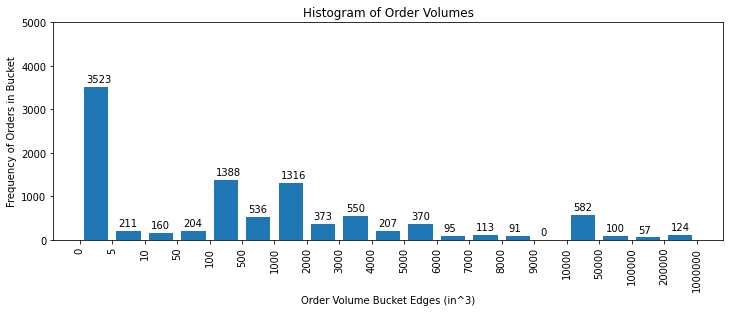

In [75]:
%matplotlib inline

# Define function to bucket volumes into format that can be equally spaced on graph
def bins_v(row):
    if 0 <= row < 5:
        bin_val = 1
    elif 5 <= row < 10:
        bin_val = 2
    elif 10 <= row < 50:
        bin_val = 3
    elif 50 <= row < 100:
        bin_val = 4
    elif 100 <= row < 500:
        bin_val = 5
    elif 500 <= row < 1000:
        bin_val = 6
    elif 1000 <= row < 2000:
        bin_val = 7
    elif 2000 <= row < 3000:
        bin_val = 8
    elif 3000 <= row < 4000:
        bin_val = 9
    elif 4000 <= row < 5000:
        bin_val = 10
    elif 5000 <= row < 6000:
        bin_val = 11
    elif 6000 <= row < 7000:
        bin_val = 12
    elif 7000 <= row < 8000:
        bin_val = 13
    elif 8000 <= row < 9000:
        bin_val = 14
    elif 90000 <= row < 10000:
        bin_val = 15
    elif 10000 <= row < 50000:
        bin_val = 16
    elif 50000 <= row < 100000:
        bin_val = 17
    elif 100000 <= row < 200000:
        bin_val = 18
    else:
        bin_val = 19
    return bin_val

# create new column for scalar bucket values (applying above function to volumes)
df_volume = df['VOLUME_IN3'].copy()
df_volumes = pd.DataFrame({'VOLUME_IN3':df_volume,'Bin_values':df_volume.apply(bins_v)})

# adjust plot size
plt.figure(figsize=(12, 4))

# create histogram of manually created histogram buckets
n,bins,patches = plt.hist(df_volumes['Bin_values'],bins=range(1,21),rwidth=0.75)

# reset x axis labels with values of bucket edges
x = range(1,21)
values = ['0','5','10','50','100','500','1000','2000','3000','4000','5000','6000','7000','8000','9000','10000','50000','100000','200000','1000000']
plt.xticks(x,values, rotation=90)

# add in values above histogram bars
for i in range(1,20):
    plt.text(bins[i-1]+0.2,n[i-1] +100,str(int(n[i-1])))

# add in x-axis label
plt.xlabel('Order Volume Bucket Edges (in^3)')

#add in y-axis label
plt.ylabel('Frequency of Orders in Bucket')

# set y axis min/max values
plt.ylim(0,5000)    

# add title to graph
plt.title('Histogram of Order Volumes')

# display histogram plot
plt.show()

#### 35% of the orders are under 5in^3. The rest of the orders are spread amongst a huge range of volumes with 14% falling between 100-500 in^3 and 13% falling between 1000-2000in^3. 

### Order Expense Histogram

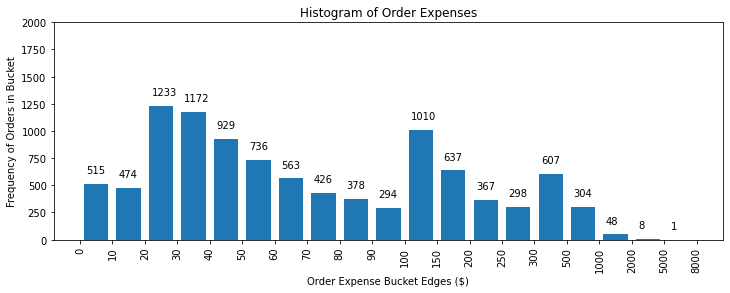

In [76]:
%matplotlib inline

# Define function to bucket expenses into format that can be equally spaced on graph
def bins_e(row):
    if 0 <= row < 10:
        bin_val = 1
    elif 10 <= row < 20:
        bin_val = 2
    elif 20 <= row < 30:
        bin_val = 3
    elif 30 <= row < 40:
        bin_val = 4
    elif 40 <= row < 50:
        bin_val = 5
    elif 50 <= row < 60:
        bin_val = 6
    elif 60 <= row < 70:
        bin_val = 7
    elif 70 <= row < 80:
        bin_val = 8
    elif 80 <= row < 90:
        bin_val = 9
    elif 90 <= row < 100:
        bin_val = 10
    elif 100 <= row < 150:
        bin_val = 11
    elif 150 <= row < 200:
        bin_val = 12
    elif 200 <= row < 250:
        bin_val = 13
    elif 250 <= row < 300:
        bin_val = 14
    elif 300 <= row < 500:
        bin_val = 15
    elif 500 <= row < 1000:
        bin_val = 16
    elif 1000 <= row < 2000:
        bin_val = 17
    elif 2000 <= row < 5000:
        bin_val = 18
    else:
        bin_val = 19
    return bin_val

# create new column for scalar bucket values (applying above function to expenses)
df_expense = df['EXPENSE'].copy()
df_expenses = pd.DataFrame({'EXPENSE':df_expense,'Bin_values':df_expense.apply(bins_e)})

# adjust plot size
plt.figure(figsize=(12, 4))

# create histogram of manually created histogram buckets
n,bins,patches = plt.hist(df_expenses['Bin_values'],bins=range(1,21),rwidth=0.75)

# reset x axis labels with values of bucket edges
x = range(1,21)
values = ['0','10','20','30','40','50','60','70','80','90','100','150','200','250','300','500','1000','2000','5000','8000']
plt.xticks(x,values, rotation=90)

# add in values above histogram bars
for i in range(1,20):
    plt.text(bins[i-1]+0.2,n[i-1] +100,str(int(n[i-1])))

# add in x-axis label
plt.xlabel('Order Expense Bucket Edges ($)')

# add in y-axis label
plt.ylabel('Frequency of Orders in Bucket')

# set y axis min/max values
plt.ylim(0,2000) 

# add title to graph
plt.title('Histogram of Order Expenses')

# display histogram plot
plt.show()

#### The distribution of order expense is much more even than weight or volume. 12.3% of orders have expense between 20 and 30 dollars, with another 11.7% of orders with expense between 30 and 40 dollars. Worth noting there is another 10% of orders that have expense between 100-150 dollars.

### Order Distance Histogram

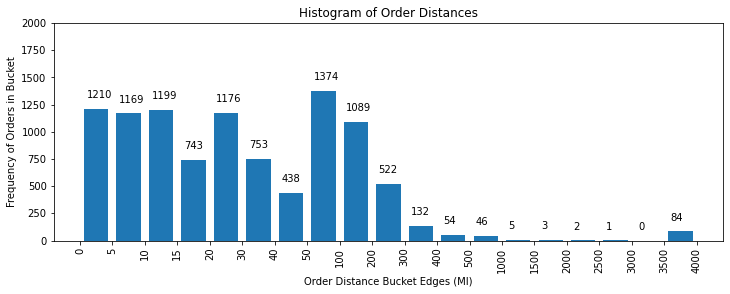

In [77]:
%matplotlib inline

# Define function to bucket distances into format that can be equally spaced on graph
def bins_d(row):
    if 0 <= row < 5:  
        bin_val = 1
    elif 5 <= row < 10:
        bin_val = 2
    elif 10 <= row < 15:
        bin_val = 3
    elif 15 <= row < 20:
        bin_val = 4
    elif 20 <= row < 30:
        bin_val = 5
    elif 30 <= row < 40:
        bin_val = 6
    elif 40 <= row < 50:
        bin_val = 7
    elif 50 <= row < 100:
        bin_val = 8
    elif 100 <= row < 200:
        bin_val = 9
    elif 200 <= row < 300:
        bin_val = 10
    elif 300 <= row < 400:
        bin_val = 11
    elif 400 <= row < 500:
        bin_val = 12
    elif 500 <= row < 1000:
        bin_val = 13
    elif 1000 <= row < 1500:
        bin_val = 14
    elif 1500 <= row < 2000:
        bin_val = 15
    elif 2000 <= row < 2500:
        bin_val = 16
    elif 2500 <= row < 3000:
        bin_val = 17
    elif 3500 <= row < 4000:
        bin_val = 18
    else:
        bin_val = 19
    return bin_val

# create new column for scalar bucket values (applying above function to distances)
df_distance = df['DISTANCE_MI'].copy()
df_distances = pd.DataFrame({'DISTANCE_MI':df_distance,'Bin_values':df_distance.apply(bins_d)})

# adjust plot size
plt.figure(figsize=(12, 4))

# create histogram of manually created histogram buckets
n,bins,patches = plt.hist(df_distances['Bin_values'],bins=range(1,21),rwidth=0.75)

# reset x axis labels with values of bucket edges
x = range(1,21)
values = ['0','5','10','15','20','30','40','50','100','200','300','400','500','1000','1500','2000','2500','3000','3500','4000']
plt.xticks(x,values, rotation=90)

# add in values above histogram bars
for i in range(1,20):
    plt.text(bins[i-1]+0.2,n[i-1] +100,str(int(n[i-1])))

# add in x-axis label
plt.xlabel('Order Distance Bucket Edges (MI)')

# add in y-axis label
plt.ylabel('Frequency of Orders in Bucket')
    
# set y axis min/max values 
plt.ylim(0,2000) 

# add title to graph
plt.title('Histogram of Order Distances')

# display histogram plot
plt.show()

#### 96.7% of orders have a distance of less than 300 miles. 36% of the orders have a distance of less than 15 miles. 11.7% of orders have a distance between 20-30 miles. 13.7% of orders have a distance between 50-100 miles. 10.9% of orders have a distance between 100-200 miles. This data shows that most of the orders being placed are for shorter distances (within city/state) opposed to interstate or cross country distances.  

## Look at records with 0 weight or volume

In [99]:
# create boolean dataframe for records where volume or weight is equal to 0
boolean = (df['VOLUME_IN3'] == 0) | (df['WEIGHT_LBS'] == 0)

rows = df[boolean].shape[0]
print(f'There are {rows} rows of data with either 0 weight or 0 volume')
print('\n')

# display all records for boolean condition above, hiding index and using 2 decimal places
df[boolean].style.hide_index().set_precision(2)

There are 25 rows of data with either 0 weight or 0 volume




ORDER_ID,COMPANY_ID,SERVICE_LINE,DRIVER_TYPE,WEIGHT_LBS,VOLUME_IN3,EXPENSE,PICKUP_ZIP,DELIVERY_ZIP,DISTANCE_MI
100474,722,1,commander,0.00,512.00,264.76,11788,01201,123.92
101127,871,1,agent,1.00,0.00,98.08,90015,90005,2.19
101669,231,1,commander,1.00,0.00,29.08,33619,33606,5.60
102626,715,1,commander,0.00,0.00,64.88,98177,98405,38.19
102644,1128,1,agent,0.00,0.00,50.93,97401,97477,3.68
102647,1296,1,commander,40.00,0.00,244.05,63011,66212,245.70
102671,1128,1,commander,0.00,0.00,41.68,92860,92503,5.86
102701,678,1,commander,0.00,0.00,76.79,92804,91007,23.76
104742,582,1,commander,0.00,0.00,62.47,91910,92126,21.71
104802,678,1,commander,0.00,0.00,63.48,90254,91007,29.33


#### There are several orders with both 0 weight and 0 volume, which could perhaps be a document or something that doesn't have form to record. However, there are 5 records with either a significant weight and no volume or vice versa. I expect something was not recorded correctly here, but because of the small number of records it shouldn't affect any of the calculations performed in this analysis.

## Look at records with 0 expense

In [79]:
# print number of records with zero expense
a = df[df['EXPENSE']==0].shape[0]
print(f'There are {a} orders with $0 expense.')

# display order records where expense is equal to $0
df[df['EXPENSE']==0].style.hide_index().set_precision(2)

There are 509 orders with $0 expense.


ORDER_ID,COMPANY_ID,SERVICE_LINE,DRIVER_TYPE,WEIGHT_LBS,VOLUME_IN3,EXPENSE,PICKUP_ZIP,DELIVERY_ZIP,DISTANCE_MI
100055,1069,2,agent,30.00,27000.00,0.00,75063,77072,260.87
100064,1127,1,agent,25.00,1000.00,0.00,90638,92706,13.09
100097,1127,1,agent,50.00,2000.00,0.00,90638,91791,13.98
100240,1127,1,agent,25.00,1000.00,0.00,90638,92706,13.09
100291,1127,1,agent,25.00,1000.00,0.00,90638,91791,13.98
100329,1127,1,agent,25.00,1000.00,0.00,90638,92706,13.09
100331,1127,1,agent,25.00,1000.00,0.00,90638,91791,13.98
100351,371,1,agent,1.00,1.00,0.00,95963,95834,93.99
100350,371,1,agent,1.00,1.00,0.00,95965,95834,73.61
100379,1163,1,agent,10.00,1.00,0.00,56431,55112,109.22


#### The number of orders with no expense is significant (over 5% of total data). It's hard to assume whether this is a data error without understanding the expense structure. However, there are several companies that have multiple orders in this dataset. Lets look at this data by company to see how many companies make up this subset of data.

## Records with 0 expense by customer

In [80]:
# filter data for orders with 0 expense, and for columns we can aggregate
zero_exp = df[df['EXPENSE']==0][['ORDER_ID','COMPANY_ID','WEIGHT_LBS','VOLUME_IN3','EXPENSE','DISTANCE_MI']]

# group values on company_id
## count order_id
## sum weight_lbs
## sum volume_in3
## sum expense
## sum distance_mi
zero_exp = zero_exp.groupby('COMPANY_ID', as_index=False).agg({'ORDER_ID':'count','WEIGHT_LBS':'sum','VOLUME_IN3':'sum','EXPENSE':'sum','DISTANCE_MI':'sum'})

# rename columns 
zero_exp = zero_exp.rename(columns={'ORDER_ID':'ORDER_COUNT','WEIGHT_LBS':'TOTAL_WEIGHT','VOLUME_IN3':'TOTAL_VOLUME','EXPENSE':'TOTAL_EXPENSE','DISTANCE_MI':'TOTAL_DISTANCE'})

# sort rows on order_count descending
zero_exp = zero_exp.sort_values(by=['ORDER_COUNT'],ascending=False)

# display data 
zero_exp.style.hide_index().set_precision(2)

COMPANY_ID,ORDER_COUNT,TOTAL_WEIGHT,TOTAL_VOLUME,TOTAL_EXPENSE,TOTAL_DISTANCE
573,208,208.00,208.00,0.00,2925.95
1026,151,987.00,167152.00,0.00,461.22
1127,58,1850.00,74000.00,0.00,784.85
1163,27,119.00,29.00,0.00,4370.17
1069,18,1980.00,1782000.00,0.00,4695.73
371,12,12.00,12.00,0.00,1014.18
680,5,5.00,5.00,0.00,221.98
668,4,1.00,288.00,0.00,1015.07
917,4,105.00,25150.00,0.00,211.81
107,3,65.00,3691.00,0.00,236.51


#### There are a few customers with a large number of orders who have no expense. Company 573 has 208 orders with no recorded expense. Company 19 has 151 orders with no expense.This should be validated by someone at Airspace.

## Data by Customer
### Totals and Percentages

In [81]:
# create subset of dataframe with Order_ID and Company ID columns
## count instances of Order_ID grouped by Company_ID
## sum total expense of orders grouped by Company_ID
## sum total weight of orders grouped by company
## sum total volume of orders grouped by company
order_count = df[['ORDER_ID','COMPANY_ID', 'EXPENSE','WEIGHT_LBS','VOLUME_IN3','DISTANCE_MI']].groupby('COMPANY_ID',as_index=False).agg({'ORDER_ID':'count','EXPENSE':'sum','WEIGHT_LBS':'sum','VOLUME_IN3':'sum','DISTANCE_MI':'sum'})

# rename count column to ORDER_COUNT
order_count = order_count.rename(columns={'ORDER_ID':'ORDER_COUNT','EXPENSE':'TOTAL_EXPENSE','WEIGHT_LBS':'TOTAL_WEIGHT','VOLUME_IN3':'TOTAL_VOLUME','DISTANCE_MI':'TOTAL_DISTANCE'}).sort_values(by=['TOTAL_EXPENSE'], ascending=False)

# Calculate percentage of total orders using ORDER_COUNT for each company
order_count['PERC_ORDERS'] = order_count['ORDER_COUNT']/order_count['ORDER_COUNT'].sum()*100

# Calculate percentage of total expense paid using Total_Expense for each company
order_count['PERC_EXPENSE'] = order_count['TOTAL_EXPENSE']/order_count['TOTAL_EXPENSE'].sum()*100

# Calculate percentage of total weight using TOTAL_WEIGHT for each company
order_count['PERC_WEIGHT'] = order_count['TOTAL_WEIGHT']/order_count['TOTAL_WEIGHT'].sum()*100

# Calculate percentage of total volumne using TOTAL_VOLUME for each company
order_count['PERC_VOLUME'] = order_count['TOTAL_VOLUME']/order_count['TOTAL_VOLUME'].sum()*100

# Calculate percentage of total distance using TOTAL_DISTANCE for each company
order_count['PERC_DIST'] = order_count['TOTAL_DISTANCE']/order_count['TOTAL_DISTANCE'].sum()*100

# round decimal places to 2
order_count = order_count.round(decimals=2)

# Displays top 10 records sorted by ORDER_COUNT
order_count.head(10).style.hide_index().set_precision(2)

COMPANY_ID,ORDER_COUNT,TOTAL_EXPENSE,TOTAL_WEIGHT,TOTAL_VOLUME,TOTAL_DISTANCE,PERC_ORDERS,PERC_EXPENSE,PERC_WEIGHT,PERC_VOLUME,PERC_DIST
980,573,54300.81,3498.50,680525.75,17500.42,5.73,4.47,0.48,1.26,2.84
917,204,53494.35,9692.00,1790273.50,31384.87,2.04,4.40,1.32,3.32,5.09
14,109,52699.61,21118.30,5116139.01,21447.78,1.09,4.33,2.87,9.49,3.48
667,364,39450.50,3448.00,826421.00,16127.59,3.64,3.24,0.47,1.53,2.62
107,319,38325.97,4496.00,604120.88,20784.49,3.19,3.15,0.61,1.12,3.37
157,148,33183.72,6146.40,515436.00,18144.54,1.48,2.73,0.84,0.96,2.94
573,685,32440.07,834.00,41451.00,13388.19,6.85,2.67,0.11,0.08,2.17
371,347,31939.11,500425.00,3931.00,16564.42,3.47,2.63,68.04,0.01,2.69
1127,398,30565.80,9148.00,504176.00,6552.23,3.98,2.51,1.24,0.94,1.06
179,209,26098.69,1711.00,400701.25,17980.90,2.09,2.15,0.23,0.74,2.92


#### It appears that customers with the highest number of orders don't pay a proportionate amount expense. Company 980 paid the most total expense but had over 100 fewer orders than company 573. Its obvious looking at the percentage of total weight that expense does not depend on weight either since several top paying companies have less than 1% of the total weight. Volume seems to be somewhat correlated since several top paying companies have more than 1% of the total volume. Distance appears to be the variable influencing expense since most with the top paying companies have over 2% of the total distance. I will calculate correlation coefficients between these variables below. 

## Calculate correlations between expense and weight/volume/distance

In [82]:
# calculate pearson correlation coefficient (r value) between Expense and Weight
a = df['EXPENSE'].corr(df['WEIGHT_LBS']).round(decimals=4)
print(f'The correlation coefficient between expense and weight is {a}')

# calculate pearson correlation coefficient (r value) between Expense and Volume
b = df['EXPENSE'].corr(df['VOLUME_IN3']).round(decimals=4)
print(f'The correlation coefficient between expense and volume is {b}')

# calculate pearson correlation coefficient (r value) between Expense and Distance
c = df['EXPENSE'].corr(df['DISTANCE_MI']).round(decimals=4)
print(f'The correlation coefficient between expense and distance is {c}')


The correlation coefficient between expense and weight is 0.004
The correlation coefficient between expense and volume is 0.3589
The correlation coefficient between expense and distance is 0.7128


#### There is no correlation between the weight of an order and the order's expense. There is a small correlation between the volume of an order and the order's expense. There is a strong correlation between the distance an order travels and the order's expense. Therefore, a company's expense will depend mostly on the distance an order has to travel and the number of orders they place.

## Histogram of Order Count by Customer

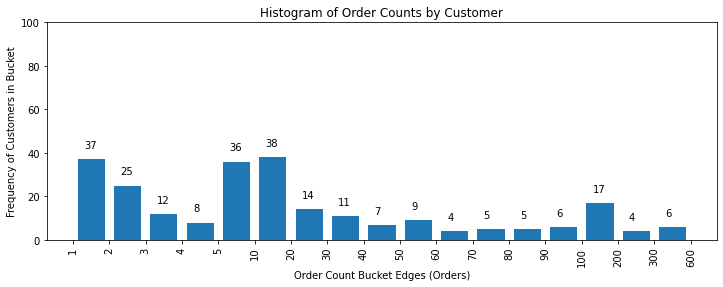

In [83]:
%matplotlib inline

# Define function to order counts by customer into format that can be equally spaced on graph
def bins_oc(row):
    if 1 <= row < 2:  
        bin_val = 1
    elif 2 <= row < 3:
        bin_val = 2
    elif 3 <= row < 4:
        bin_val = 3
    elif 4 <= row < 5:
        bin_val = 4
    elif 5 <= row < 10:
        bin_val = 5
    elif 10 <= row < 20:
        bin_val = 6
    elif 20 <= row < 30:
        bin_val = 7
    elif 30 <= row < 40:
        bin_val = 8
    elif 40 <= row < 50:
        bin_val = 9
    elif 50 <= row < 60:
        bin_val = 10
    elif 60 <= row < 70:
        bin_val = 11
    elif 70 <= row < 80:
        bin_val = 12
    elif 80 <= row < 90:
        bin_val = 13
    elif 90 <= row < 100:
        bin_val = 14
    elif 100 <= row < 200:
        bin_val = 15
    elif 200 <= row < 300:
        bin_val = 16
    else:
        bin_val = 17
    return bin_val

# create new column for scalar bucket values (applying above function to order count)
df_oc = order_count['ORDER_COUNT'].copy()
df_ocs = pd.DataFrame({'ORDER_COUNT':df_oc,'Bin_values':df_oc.apply(bins_oc)})

# adjust plot size
plt.figure(figsize=(12, 4))

# create histogram of manually created histogram buckets
n,bins,patches = plt.hist(df_ocs['Bin_values'],bins=range(1,19),rwidth=0.75)

# reset x axis labels with values of bucket edges
x = range(1,19)
values = ['1','2','3','4','5','10','20','30','40','50','60','70','80','90','100','200','300','600']
plt.xticks(x,values, rotation=90)

# add in values above histogram bars
for i in range(1,18):
    plt.text(bins[i-1]+0.3,n[i-1] +5,str(int(n[i-1])))

# add in x-axis label
plt.xlabel('Order Count Bucket Edges (Orders)')

# add in y-axis label
plt.ylabel('Frequency of Customers in Bucket')
    
# set y axis min/max values 
plt.ylim(0,100) 

# display histogram plot
plt.title('Histogram of Order Counts by Customer')

# display histogram plot
plt.show()

#### There is a wide distribution of orders per customer. There are 37 customers with only 1 order (which I list out below) and 25 customers with only 2 orders. Overall, there are 82 customers with less than 5 orders (33% of customers) and 156 customers (64% of customers) with less than 20 orders. I would increase attention on these companies to try and increase their order volume. 

## Top 5 Customers by Order Count

In [84]:
# Create subset from above order_count dataframe and sort by order_count, desc
co_t = order_count[['COMPANY_ID','ORDER_COUNT','PERC_ORDERS']].sort_values(by=['ORDER_COUNT'],ascending=False)
co_t.head().style.hide_index()

COMPANY_ID,ORDER_COUNT,PERC_ORDERS
573,685,6.850000
980,573,5.730000
1127,398,3.980000
667,364,3.640000
371,347,3.470000


## List of Companies with Only 1 Order

In [85]:
# Create subset from above order_count dataframe filtered by order_count = 1
co_b = order_count[['COMPANY_ID','ORDER_COUNT']]
co_b = co_b[co_b['ORDER_COUNT']==1]
co_b.style.hide_index()

COMPANY_ID,ORDER_COUNT
517,1
168,1
855,1
1150,1
916,1
24,1
1058,1
373,1
1230,1
722,1


## Top 5 Customers by Expense

In [86]:
# Create subset from above order_count dataframe and sort by total expense, desc
ce_t = order_count[['COMPANY_ID','TOTAL_EXPENSE','PERC_EXPENSE']].sort_values(by=['TOTAL_EXPENSE'],ascending=False)
ce_t.head().style.hide_index().set_precision(2)

COMPANY_ID,TOTAL_EXPENSE,PERC_EXPENSE
980,54300.81,4.47
917,53494.35,4.40
14,52699.61,4.33
667,39450.50,3.24
107,38325.97,3.15


## Top 5 Customers by Weight

In [87]:
# Create subset from above order_count dataframe and sort by total weight, desc
cw_t = order_count[['COMPANY_ID','TOTAL_WEIGHT','PERC_WEIGHT']].sort_values(by=['TOTAL_WEIGHT'],ascending=False)
cw_t.head().style.hide_index().set_precision(2)

COMPANY_ID,TOTAL_WEIGHT,PERC_WEIGHT
371,500425.00,68.04
14,21118.30,2.87
1069,14156.00,1.92
917,9692.00,1.32
149,9664.97,1.31


#### As mentioned above, the one order with a weight of 500,000 should be investigated. If it's determined that the weight value is erroneous than this dataset should be adjusted. The weight data and in particular the percentage of weight per customer is very skewed by that one order.

## Top 5 Customers by Distance

In [88]:
# Create subset from above order_count dataframe and sort by total distance, desc
cd_t = order_count[['COMPANY_ID','TOTAL_DISTANCE','PERC_DIST']].sort_values(by=['TOTAL_DISTANCE'],ascending=False)
cd_t.head().style.hide_index().set_precision(2)

COMPANY_ID,TOTAL_DISTANCE,PERC_DIST
917,31384.87,5.09
14,21447.78,3.48
107,20784.49,3.37
157,18144.54,2.94
179,17980.90,2.92


#### Customer 917's orders make up 5.1% of the total distance for this dataset. This customer is also in the top 5 customers for total weight, meaning they are moving heavy items long distances.

## Top 5 Customers by Volume

In [89]:
# Create subset from above order_count dataframe and sort by total volume, desc
cv_t = order_count[['COMPANY_ID','TOTAL_VOLUME','PERC_VOLUME']].sort_values(by=['TOTAL_VOLUME'],ascending=False)
cv_t.head().style.hide_index().set_precision(2)

COMPANY_ID,TOTAL_VOLUME,PERC_VOLUME
1069,11370416.00,21.09
14,5116139.01,9.49
917,1790273.50,3.32
1140,1770895.94,3.29
149,1748295.41,3.24


#### Company 1069 accounts for 21% of the total order volume, but isnt in the top 5 customers for order count. It's also worth noting that this company only accounts for 1.92% of the total weight. This means that this customer is moving very large items that aren't proportionately heavy. 

## Count and Perc. of Orders by Service Line

In [90]:
# create subset of dataframe with Order_ID and SERVICE_LINE columns
# count instances of Order_ID grouped by SERVICE_LINE
type_count = df[['SERVICE_LINE','ORDER_ID','WEIGHT_LBS', 'VOLUME_IN3', 'EXPENSE','DISTANCE_MI']].groupby('SERVICE_LINE')\
            .agg({'ORDER_ID':'count','WEIGHT_LBS':'sum','VOLUME_IN3':'sum','EXPENSE':'sum','DISTANCE_MI':'sum'})

# rename count column to ORDER_COUNT
type_count = type_count.rename(columns={'ORDER_ID':'ORDERS','WEIGHT_LBS':'SUM_WEIGHT','VOLUME_IN3':'SUM_VOL',\
                'EXPENSE':'SUM_EXP','DISTANCE_MI':'SUM_DIST'}).sort_values(by=['ORDERS'],ascending=False)

# Calculate percentage of total orders by Order_Type
type_count['%_ORDERS'] = type_count['ORDERS']/type_count['ORDERS'].sum()*100

# Calculate percentage of total weight by Order_Type
type_count['%_WEIGHT'] = type_count['SUM_WEIGHT']/type_count['SUM_WEIGHT'].sum()*100

# Calculate percentage of total volume by Order_Type
type_count['%_VOLUME'] = type_count['SUM_VOL']/type_count['SUM_VOL'].sum()*100

# Calculate percentage of total volume by Order_Type
type_count['%_EXP'] = type_count['SUM_EXP']/type_count['SUM_EXP'].sum()*100

# Calculate percentage of total distance by Order_Type
type_count['%_DIST'] = type_count['SUM_DIST']/type_count['SUM_DIST'].sum()*100

# display data sorted by ORDER_COUNT
type_count.style.set_precision(2)

,ORDERS,SUM_WEIGHT,SUM_VOL,SUM_EXP,SUM_DIST,%_ORDERS,%_WEIGHT,%_VOLUME,%_EXP,%_DIST
SERVICE_LINE,,,,,,,,,,
1,9552,596708.96,17075226.96,1027666.13,550187.65,95.52,81.13,31.68,84.52,89.28
2,448,138792.20,36826606.39,188271.52,66080.54,4.48,18.87,68.32,15.48,10.72


####  95.5% of the orders are Service Line 1 vs 4.48% Service Line 2. However, service line 1 orders do not account for a proportionate amount of weight, volume, expense, or distance. Service line 2 orders make up 18.9% of the weight and 68.32% of the total volume. Service line 2 orders also account for 15.5% of the total expense and 10.7% of the total distance. This tells me that Service Line 2 orders tend to be larger items that travel greater average distance and are therefore more expensive.

## Count and Perc. of Orders by Driver Type

In [91]:
# create subset of dataframe with Order_ID and Driver_Type columns
# count instances of Order_ID grouped by Driver_Type
driver_count = df[['DRIVER_TYPE','ORDER_ID','WEIGHT_LBS', 'VOLUME_IN3', 'EXPENSE','DISTANCE_MI']].groupby('DRIVER_TYPE')\
            .agg({'ORDER_ID':'count','WEIGHT_LBS':'sum','VOLUME_IN3':'sum','EXPENSE':'sum','DISTANCE_MI':'sum'})

# rename count column to ORDER_COUNT
driver_count = driver_count.rename(columns={'ORDER_ID':'ORDERS','WEIGHT_LBS':'SUM_WEIGHT','VOLUME_IN3':'SUM_VOL',\
                'EXPENSE':'SUM_EXP','DISTANCE_MI':'SUM_DIST'}).sort_values(by=['ORDERS'],ascending=False)

# Calculate percentage of total orders by Order_Type
driver_count['%_ORDERS'] = driver_count['ORDERS']/driver_count['ORDERS'].sum()*100

# Calculate percentage of total weight by Order_Type
driver_count['%_WEIGHT'] = driver_count['SUM_WEIGHT']/driver_count['SUM_WEIGHT'].sum()*100

# Calculate percentage of total volume by Order_Type
driver_count['%_VOLUME'] = driver_count['SUM_VOL']/driver_count['SUM_VOL'].sum()*100

# Calculate percentage of total volume by Order_Type
driver_count['%_EXP'] = driver_count['SUM_EXP']/driver_count['SUM_EXP'].sum()*100

# Calculate percentage of total distance by Order_Type
driver_count['%_DIST'] = driver_count['SUM_DIST']/driver_count['SUM_DIST'].sum()*100

# display data sorted by Order_Count
driver_count.style.set_precision(2)

,ORDERS,SUM_WEIGHT,SUM_VOL,SUM_EXP,SUM_DIST,%_ORDERS,%_WEIGHT,%_VOLUME,%_EXP,%_DIST
DRIVER_TYPE,,,,,,,,,,
commander,6173,70194.00,14408021.33,582786.92,345709.80,61.73,9.54,26.73,47.93,56.10
agent,3827,665307.16,39493812.03,633150.73,270558.39,38.27,90.46,73.27,52.07,43.90


#### 61.73% of the orders used the commander driver type vs 38.27% for the agent driver type. However, the orders that used commander driver type had proportionately smaller weight, volume, expense, and distance. The 38.27% of agent orders made up 90.46% of the total weight. The agent orders also had 73.27% of the total volume and 52% of the expense. This tells me that agent driver types are used to transport larger and heavier items, resulting in more expensive orders.

# Summary

#### - There are 48 order records with invalid zip code entries (less than 5 digits)
#### - There are 396 orders where pickup and delivery is in the same zip code (4% of orders)
#### - There are 244 unique customers in the dataset
#### - Avg order weight = 73.55 lbs
#### - Avg order volume = 5390.18 in^3
#### - Avg order distance = 62.15 miles
#### - Avg order expense = 121.59 USD
#### - Order 105002 has a recorded weight of 500,000 lbs (doesn't seem possible)
#### - 25 orders have 0 recorded weight, volume, or both
#### - 509 orders have 0 recorded expense (5% of total data)
#### - Two customers have over 100 orders each with no recorded expense
#### - 85% of orders are less than 30lb with 41% between 1lb and 2lb
#### - 35% of orders have less than 5in^3 of volume
#### - 96.7% of orders have a distance of less than 300 miles with 36% less than 15 miles
#### - Customers with largest number of orders don't pay proportionate amount of expense
#### - Expense of an order is most strongly correlated to distance as an individual variable
#### - 33% of customers have less than 5 orders, with 37 customers having only 1 order
#### - 95.5% of orders are service line 1
#### - Service line 2 orders have larger weights, volumes, distances, and expenses
#### - 61.7% of orders used the commander driver type
#### - Agent driver type is used to transport larger and heavier items